In [1]:
import numpy as np
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import matplotlib.pyplot as plt
from seisLM.utils.project_path import gitdir
NUM_CLASSES = 4

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from speechbrain.lobes.models.ECAPA_TDNN import AttentiveStatisticsPooling
import einops

inp_tensor = torch.rand([8, 64, 120])
asp_layer = AttentiveStatisticsPooling(64)
einops.rearrange(asp_layer(inp_tensor), 'b c 1 -> b c').shape

torch.Size([8, 128])

In [3]:
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import (
  Conv1DShockClassifierLit, Wav2vec2ShockClassifierLit)

# from seisLM.model.task_specific.foreshock_aftershock_models import ShockClassifierLit #Wav2Vec2ForSequenceClassification

def get_seisLM_config():

  config_path = gitdir() + '/seisLM/configs/foreshock_aftershock/seisLM_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)

  config.model_args.num_classes = NUM_CLASSES
  return config


def get_conv1d_config():
  config_path = gitdir() + '/seisLM/configs/foreshock_aftershock/conv1d_shock_classifier.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)
  config.model_args.num_classes = NUM_CLASSES
  return config



seisLM_config = get_seisLM_config()
conv1d_config = get_conv1d_config()

models = {}

models['seisLM'] = Wav2vec2ShockClassifierLit(
  model_config=seisLM_config.model_args,
  training_config=seisLM_config.trainer_args,
  ).model


models['cnn'] = Conv1DShockClassifierLit(
  model_config=conv1d_config.model_args,
  training_config=conv1d_config.trainer_args,
  ).model


In [4]:
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=seisLM_config.model_args.num_classes,
  **seisLM_config.data_args
)

Seed set to 42
Seed set to 42


In [5]:
from sklearn.metrics import accuracy_score


for key, model in models.items():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = models[key].to(device)

  all_gt_class = []
  all_pred_class = []
  all_losses = []

  for X, y in loaders['test']:
    with torch.no_grad():
      logits = model(X.to(device)).cpu()
      pred_class = np.argmax(logits.numpy(), axis=1)
      loss = torch.nn.functional.cross_entropy(logits, y)

    all_gt_class.append(y)
    all_pred_class.append(pred_class)
    all_losses.append(loss)

  all_gt_class = np.concatenate(all_gt_class)
  all_pred_class = np.concatenate(all_pred_class)
  all_losses = np.array(all_losses)

  print(f'model {key} acc at init', accuracy_score(all_gt_class, all_pred_class))
  print(f'model {key} loss at init', np.mean(all_losses))

model seisLM acc at init 0.2451657458563536
model seisLM loss at init 1.408571
model cnn acc at init 0.2223756906077348
model cnn loss at init 1.3977145


In [6]:
models['seisLM'].wav2vec2.encoder.layers[0].attention.k_proj.weight.requires_grad

True

Text(0.5, 1.0, 'Wav2Vec2 last hidden states')

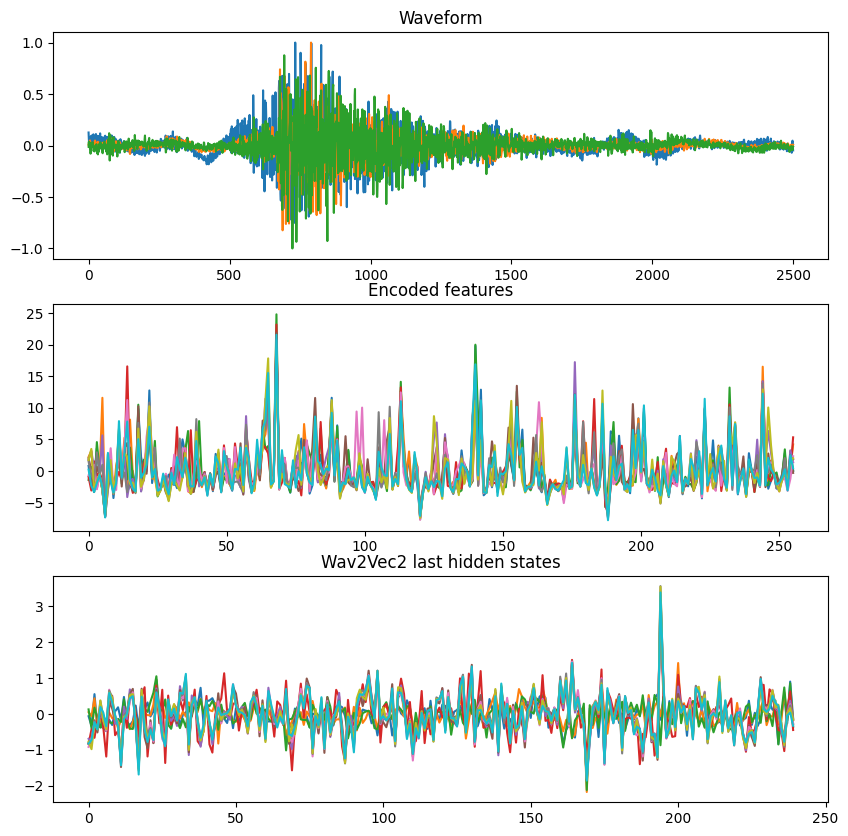

In [7]:
model = models['seisLM']

waveforms, _ = next(iter(loaders['test']))

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
sample_idx = 0
num_channels_to_display = 10

with torch.no_grad():
  wav2vec2_outputs = model.wav2vec2(waveforms.to(device))

axes[0].plot(waveforms[0].T)
axes[0].set_title('Waveform')

axes[1].plot(wav2vec2_outputs.extract_features[0][:num_channels_to_display, :].detach().cpu().numpy().T)
axes[1].set_title('Encoded features')

axes[2].plot(wav2vec2_outputs.last_hidden_state[0][:num_channels_to_display, :].detach().cpu().numpy().T)
axes[2].set_title('Wav2Vec2 last hidden states')


In [8]:
wav2vec2_outputs.extract_features.shape

torch.Size([64, 624, 256])

In [9]:
wav2vec2_outputs.last_hidden_state.shape

torch.Size([64, 624, 240])

In [10]:
seisLM_config

data_args:
  amp_norm: true
  amp_norm_type: peak
  batch_size: 64
  component_order: ZNE
  demean: true
  dimension_order: NCW
  event_split_method: temporal
  num_workers: 8
  seed: 42
  test_frac: 0.2
  train_frac: 0.7
  val_frac: 0.1
model_args:
  classifier_proj_size: 256
  dropout_rate: 0.2
  num_classes: 4
  pretrained_ckpt_path: /home/liu0003/Desktop/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_layernorm_peak_small_batch_6_datasets_42__2024-08-03-21h-32m-39s/checkpoints/epoch=14-step=394320.ckpt
  use_weighted_layer_sum: true
model_name: Wav2Vec2ForSequenceClassification
trainer_args:
  accelerator: gpu
  devices: 2
  max_epochs: 10
  optimizer: adamw
  optimizer_args:
    lr: 0.001
    weight_decay: 0.1
  strategy: ddp
  unfreeze_base_at_epoch: 0
  warmup_frac_step: 0.0

In [11]:
import numpy as np
u, s, vh = np.linalg.svd(wav2vec2_outputs.last_hidden_state[0])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

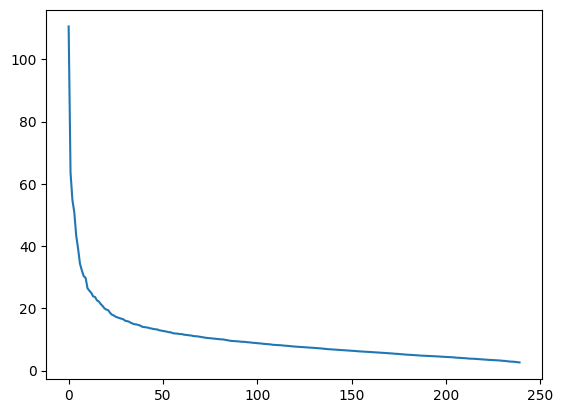

In [ ]:
plt.plot(s)

In [ ]:
seisLM_config

data_args:
  batch_size: 32
  component_order: ZNE
  demean: false
  devide_by_std: true
  dimension_order: NCW
  event_split_method: temporal
  num_workers: 8
  seed: 42
  test_frac: 0.2
  train_frac: 0.7
  val_frac: 0.1
model_args:
  classifier_proj_size: 256
  dropout_rate: 0.2
  num_classes: 4
  pretrained_ckpt_path: /scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-07-31-19h-12m-12s/checkpoints/epoch=12-step=60879.ckpt
  use_weighted_layer_sum: false
model_name: Wav2Vec2ForSequenceClassification
trainer_args:
  accelerator: gpu
  devices: 2
  max_epochs: 15
  optimizer: sgd
  optimizer_args:
    lr: 0.1
    momentum: 0.9
    weight_decay: 0.1
  strategy: ddp
  unfreeze_base_at_epoch: 0
  warmup_frac_step: 0.0

In [ ]:
torch.nn.functional.softmax(models['seisLM'].layer_weights)




AttributeError: 'Wav2Vec2ForSequenceClassification' object has no attribute 'layer_weights'

In [ ]:
import torch

from torch import nn



m = nn.Dropout1d(p=0.5)
input = torch.randn(1, 16, 240)

output = m(input)
output


tensor([[[-0.3253, -4.8297, -2.0429,  ...,  5.1758, -2.4331,  1.1259],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0272, -2.4046, -1.2682,  ..., -0.7622, -2.2524,  0.4092],
         ...,
         [-0.5418, -0.6457, -0.5993,  ...,  0.2346, -1.2143, -0.6696],
         [ 2.4198, -3.1374,  1.5998,  ..., -1.9867,  3.0819, -1.9946],
         [ 1.1361, -1.2029, -1.8196,  ...,  0.3610,  1.3950, -0.2436]]])

In [ ]:
output[0][-2].shape


torch.Size([240])

In [ ]:
output

tensor([[[-0.3253, -4.8297, -2.0429,  ...,  5.1758, -2.4331,  1.1259],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0272, -2.4046, -1.2682,  ..., -0.7622, -2.2524,  0.4092],
         ...,
         [-0.5418, -0.6457, -0.5993,  ...,  0.2346, -1.2143, -0.6696],
         [ 2.4198, -3.1374,  1.5998,  ..., -1.9867,  3.0819, -1.9946],
         [ 1.1361, -1.2029, -1.8196,  ...,  0.3610,  1.3950, -0.2436]]])